<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pip
!pip install -U japanize_matplotlib

     |████████████████████████████████| 1.5MB 5.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 4.1 MB 5.5 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=b6925cbefd940d47a4de66c0bed8a8ddade1844bb8c6b63146b7ddcd9353e4af
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [2]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import re
from pytz import timezone
from tqdm.notebook import tqdm

%matplotlib inline

### COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19/blob/development/FORKED_SITES.md

In [3]:
urls = {
    'tokyo': 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json',
#     'saitama': 'https://raw.githubusercontent.com/codefortoda/covid19-saitama/development/data/data.json',
    'aichi': 'https://raw.githubusercontent.com/code4nagoya/covid19/development/data/data.json',
#     'osaka': 'https://raw.githubusercontent.com/codeforosaka/covid19/development/data/data.json',
    'hyogo': 'https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json',
    'fukui': 'https://raw.githubusercontent.com/nomunomu0504/covid19/nomu_development/data/patients_summary.json',
    'tottori': 'https://raw.githubusercontent.com/tottori-covid19/covid19/master/data/data.json',
    'shimane': 'https://raw.githubusercontent.com/TaigaMikami/shimane-covid19/shimane/data/patients_summary.json',
    'okinawa': 'https://raw.githubusercontent.com/Code-for-OKINAWA/covid19/development/data/data.json',
    'fukuoka': 'https://raw.githubusercontent.com/Code-for-Fukuoka/covid19-fukuoka/development/data/data.json',
    'hokkaido': 'https://stopcovid19.hokkaido.dev/api/patients_summary.json',
#     'kanagawa': 'https://www.pref.kanagawa.jp/osirase/1369/data/data.json',
    ##'chiba': 'https://raw.githubusercontent.com/civictechzenchiba/covid19-chiba/development/data/data.json',
    #'hiroshima': 'https://raw.githubusercontent.com/tatsuya1970/covid19/development/data/data.json',
    'fukushima': 'https://cdn2.dott.dev/data.json',
#     'chiba': 'https://covid19chiba.s3-ap-northeast-1.amazonaws.com/DataPub.json',
    'shizuokashi': 'https://db7rdtcq3byow.cloudfront.net/data.json',
    'hamamatsushi': 'https://raw.githubusercontent.com/code-for-hamamatsu/covid19/dev-hamamatsu/data/hamamatsu/data.json',
    'shiga': 'https://shiga-pref-org.github.io/covid19-data/data.json',
}

In [4]:
def get_json_data(pref: str, url: str) -> dict:
    response = requests.get(url)
    json_data = json.loads(response.text)
    
    # json文字列をdictへ
    if pref == 'shimane':
        return json_data['patients_summary']
    if pref == 'hokkaido':
        return {'data': [{'日付': j['日付'], '小計': j['日陽性数']} for j in json_data['data']]}
    if pref == 'kanagawa':
        print(json_data['patient'])
#     print(json_data['patients_summary']['data'])
    return json_data

In [5]:
#res = get_json_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [6]:
def datetime_to_date(datestr: str) -> datetime:
    return datetime.datetime.strptime(re.sub(r'T.*$', '', datestr), '%Y-%m-%d')

In [7]:
def utc_datestr_to_jst_date(datestr: str) -> datetime:
   return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  #return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [8]:
#utc_datestr_to_jst_date('2020-08-12T12:34:56.789Z')

In [9]:
def get_patients_count(json_data: dict, file_name: str) -> list:
    if file_name == 'data.json':
        return [data['小計'] for data in json_data['patients_summary']['data']]
    return [data['小計'] for data in json_data['data']]

In [10]:
def get_df_index(json_data: dict, file_name: str):
    if file_name == 'data.json':
        return [datetime_to_date(d['日付']) for d in json_data['patients_summary']['data']]
#         return pd.date_range(
#             start=datetime_to_date(json_data['patients_summary']['data'][0]['日付']),
#             end=datetime_to_date(json_data['patients_summary']['data'][-1]['日付']),
#             freq='D')
    return [datetime_to_date(d['日付']) for d in json_data['data']]
#     return pd.date_range(
#             start=datetime_to_date(json_data['data'][0]['日付']),
#             end=datetime_to_date(json_data['data'][-1]['日付']),
#             freq='D')

In [11]:
def get_data(pref: str, url: str):
    json_data = get_json_data(pref, url)
#     print(json_data)
    file_name = url.split('/')[-1]

    # 日毎の数
    patients_count = get_patients_count(json_data, file_name)
    # dataframe index
    df_index = get_df_index(json_data, file_name)

    # データフレームにセット（インデックスに日付をセット）
    df = pd.DataFrame({'patients_count': patients_count}, index=df_index)
    # 7日間移動平均・合計カラムを追加
    try:
        df['7d_mov_ave'] = df['patients_count'].rolling('7D').mean()
        df['7d_mov_sum'] = df['patients_count'].rolling('7D').sum()
    except Exception as e:
        print(e)
        df['7d_mov_ave'] = np.zeros(len(df['patients_count']))
        df['7d_mov_sum'] = np.zeros(len(df['patients_count']))
        
    return df

In [12]:
# url = urls['tottori']
# print(url)
# res = get_data(url)
# print(type(res))
# print(res.tail(15))

In [13]:
for k, v in tqdm(urls.items()):
    print(k, v)
    res = get_data(k, v)
    #res = get_data('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
    #res = get_data('https://raw.githubusercontent.com/stop-covid19-hyogo/covid19/development/data/patients_summary.json')
    print(type(res))
    print(res.tail(15))
    print('-----')

tokyo https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json
<class 'pandas.core.frame.DataFrame'>
            patients_count  7d_mov_ave  7d_mov_sum
2021-02-25             340  279.714286      1958.0
2021-02-26             270  267.857143      1875.0
2021-02-27             337  269.285714      1885.0
2021-02-28             329  277.428571      1942.0
2021-03-01             121  269.285714      1885.0
2021-03-02             232  263.142857      1842.0
2021-03-03             316  277.857143      1945.0
2021-03-04             279  269.142857      1884.0
2021-03-05             301  273.571429      1915.0
2021-03-06             293  267.285714      1871.0
2021-03-07             237  254.142857      1779.0
2021-03-08             116  253.428571      1774.0
2021-03-09             290  261.714286      1832.0
2021-03-10             340  265.142857      1856.0
2021-03-11             335  273.142857      1912.0
-----
aichi https://raw.githubusercontent.com/co

In [14]:
def week_num(d: datetime) -> str:
    return f'\'{d.strftime("%y")}w{d.strftime("%V")}'

In [15]:
def week_num_list(l: list) -> list:
    return [week_num(d) for d in l]

In [16]:
def week_day(d: datetime) -> str:
    return d.strftime('%a')

In [17]:
def week_day_list(l: list) -> list:
    return [week_day(d) for d in l]

In [18]:
# res = pd.DataFrame({
#     'week_num': week_num_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)]),
#     'week_day': week_day_list([(datetime.datetime(2020,1,1) + datetime.timedelta(i)) for i in range(370)])
# })
# print(type(res))
# res

In [19]:
def get_df(pref: str, url: str):
    df = get_data(pref, url)
    # 日付カラムを追加
    df['datetime'] = df.index
    # 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
    df['week_num'] = week_num_list(df.index)
    # 曜日の列をセット
    df['week_day'] = week_day_list(df.index)
    return df

In [20]:
#res = get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json')
#print(type(res))
#res

In [21]:
def agg_df(df):
    # 週毎に集計
    groupby_week_num = df.groupby('week_num')
    # 集計結果から平均と合計を取得しデータフレームにセット
    return pd.DataFrame({
        'week_num': df['week_num'].unique(),
        'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
        'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
    }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])

In [22]:
# res = agg_df(get_df('https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'))
# print(type(res))
# res

In [23]:
dfs = {}
weekly_agg_dfs = {}
for k, v in tqdm(urls.items()):
    df = get_df(k, v)
    weekly_agg_df = agg_df(df)
    # 集計カラムを追加
    df = pd.concat([
        df, weekly_agg_df.loc[:, ['week_mean', 'week_sum']]
    ], axis=1)
    dfs[k] = df
#     weekly_agg_dfs[item[0]] = weekly_agg_df

#print(min([len(v) for k, v in dfs.items()]))
#print(weekly_agg_dfs)

In [24]:
pd.DataFrame({k: dfs[k]['patients_count'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-02-25,340,41.0,35.0,0.0,1.0,NaN,15.0,NaN,43.0,21.0,2.0,5.0,8.0
2021-02-26,270,40.0,24.0,0.0,0.0,NaN,23.0,NaN,36.0,12.0,2.0,9.0,12.0
2021-02-27,337,53.0,21.0,1.0,0.0,NaN,19.0,NaN,43.0,16.0,2.0,11.0,18.0
2021-02-28,329,31.0,26.0,0.0,0.0,NaN,15.0,NaN,27.0,15.0,2.0,5.0,5.0
2021-03-01,121,NaN,21.0,0.0,0.0,NaN,7.0,NaN,29.0,7.0,3.0,5.0,3.0
2021-03-02,232,NaN,44.0,0.0,0.0,NaN,17.0,NaN,29.0,38.0,0.0,7.0,11.0
2021-03-03,316,NaN,40.0,0.0,0.0,NaN,18.0,NaN,60.0,34.0,1.0,7.0,17.0
2021-03-04,279,NaN,20.0,0.0,0.0,NaN,28.0,NaN,66.0,19.0,0.0,4.0,26.0
2021-03-05,301,NaN,36.0,0.0,0.0,NaN,13.0,NaN,64.0,11.0,0.0,4.0,14.0
2021-03-06,293,NaN,15.0,0.0,0.0,NaN,27.0,NaN,47.0,24.0,0.0,6.0,8.0


In [25]:
pd.DataFrame({k: dfs[k]['7d_mov_ave'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-02-25,279.714286,42.428571,27.285714,1.000000,0.142857,NaN,13.142857,NaN,44.714286,7.428571,1.428571,10.428571,11.285714
2021-02-26,267.857143,40.857143,26.285714,0.285714,0.142857,NaN,13.714286,NaN,43.714286,8.428571,1.428571,10.857143,11.857143
2021-02-27,269.285714,41.857143,23.285714,0.428571,0.142857,NaN,14.714286,NaN,45.000000,10.714286,1.571429,11.571429,12.285714
2021-02-28,277.428571,41.571429,23.142857,0.428571,0.142857,NaN,15.857143,NaN,39.857143,12.285714,1.714286,10.571429,11.857143
2021-03-01,269.285714,NaN,24.142857,0.428571,0.142857,NaN,15.428571,NaN,41.000000,12.000000,1.857143,10.714286,10.285714
2021-03-02,263.142857,NaN,27.000000,0.428571,0.142857,NaN,15.428571,NaN,35.714286,16.714286,1.857143,8.142857,10.000000
2021-03-03,277.857143,NaN,30.142857,0.142857,0.142857,NaN,16.285714,NaN,38.142857,20.428571,1.714286,7.000000,10.571429
2021-03-04,269.142857,NaN,28.000000,0.142857,0.000000,NaN,18.142857,NaN,41.428571,20.142857,1.428571,6.857143,13.142857
2021-03-05,273.571429,NaN,29.714286,0.142857,0.000000,NaN,16.714286,NaN,45.428571,20.000000,1.142857,6.142857,13.428571
2021-03-06,267.285714,NaN,28.857143,0.000000,0.000000,NaN,17.857143,NaN,46.000000,21.142857,0.857143,5.428571,12.000000


In [26]:
pd.DataFrame({k: dfs[k]['7d_mov_sum'] for k in dfs.keys()}, index=dfs['tokyo'].index).tail(15)

,tokyo,aichi,hyogo,fukui,tottori,shimane,okinawa,fukuoka,hokkaido,fukushima,shizuokashi,hamamatsushi,shiga
2021-02-25,1958.0,297.0,191.0,7.0,1.0,NaN,92.0,NaN,313.0,52.0,10.0,73.0,79.0
2021-02-26,1875.0,286.0,184.0,2.0,1.0,NaN,96.0,NaN,306.0,59.0,10.0,76.0,83.0
2021-02-27,1885.0,293.0,163.0,3.0,1.0,NaN,103.0,NaN,315.0,75.0,11.0,81.0,86.0
2021-02-28,1942.0,291.0,162.0,3.0,1.0,NaN,111.0,NaN,279.0,86.0,12.0,74.0,83.0
2021-03-01,1885.0,NaN,169.0,3.0,1.0,NaN,108.0,NaN,287.0,84.0,13.0,75.0,72.0
2021-03-02,1842.0,NaN,189.0,3.0,1.0,NaN,108.0,NaN,250.0,117.0,13.0,57.0,70.0
2021-03-03,1945.0,NaN,211.0,1.0,1.0,NaN,114.0,NaN,267.0,143.0,12.0,49.0,74.0
2021-03-04,1884.0,NaN,196.0,1.0,0.0,NaN,127.0,NaN,290.0,141.0,10.0,48.0,92.0
2021-03-05,1915.0,NaN,208.0,1.0,0.0,NaN,117.0,NaN,318.0,140.0,8.0,43.0,94.0
2021-03-06,1871.0,NaN,202.0,0.0,0.0,NaN,125.0,NaN,322.0,148.0,6.0,38.0,84.0


In [27]:
for k, v in tqdm(dfs.items()):
    print(k)
    print(v[['week_day', 'patients_count', '7d_mov_ave', '7d_mov_sum']].tail(15))
    print('---')

tokyo
           week_day  patients_count  7d_mov_ave  7d_mov_sum
2021-02-25      Thu             340  279.714286      1958.0
2021-02-26      Fri             270  267.857143      1875.0
2021-02-27      Sat             337  269.285714      1885.0
2021-02-28      Sun             329  277.428571      1942.0
2021-03-01      Mon             121  269.285714      1885.0
2021-03-02      Tue             232  263.142857      1842.0
2021-03-03      Wed             316  277.857143      1945.0
2021-03-04      Thu             279  269.142857      1884.0
2021-03-05      Fri             301  273.571429      1915.0
2021-03-06      Sat             293  267.285714      1871.0
2021-03-07      Sun             237  254.142857      1779.0
2021-03-08      Mon             116  253.428571      1774.0
2021-03-09      Tue             290  261.714286      1832.0
2021-03-10      Wed             340  265.142857      1856.0
2021-03-11      Thu             335  273.142857      1912.0
---
aichi
           week_day  pat

In [28]:
titles = ['daily count', '7days mean', '7days sum']
x = list(dfs.items())[0][1].index

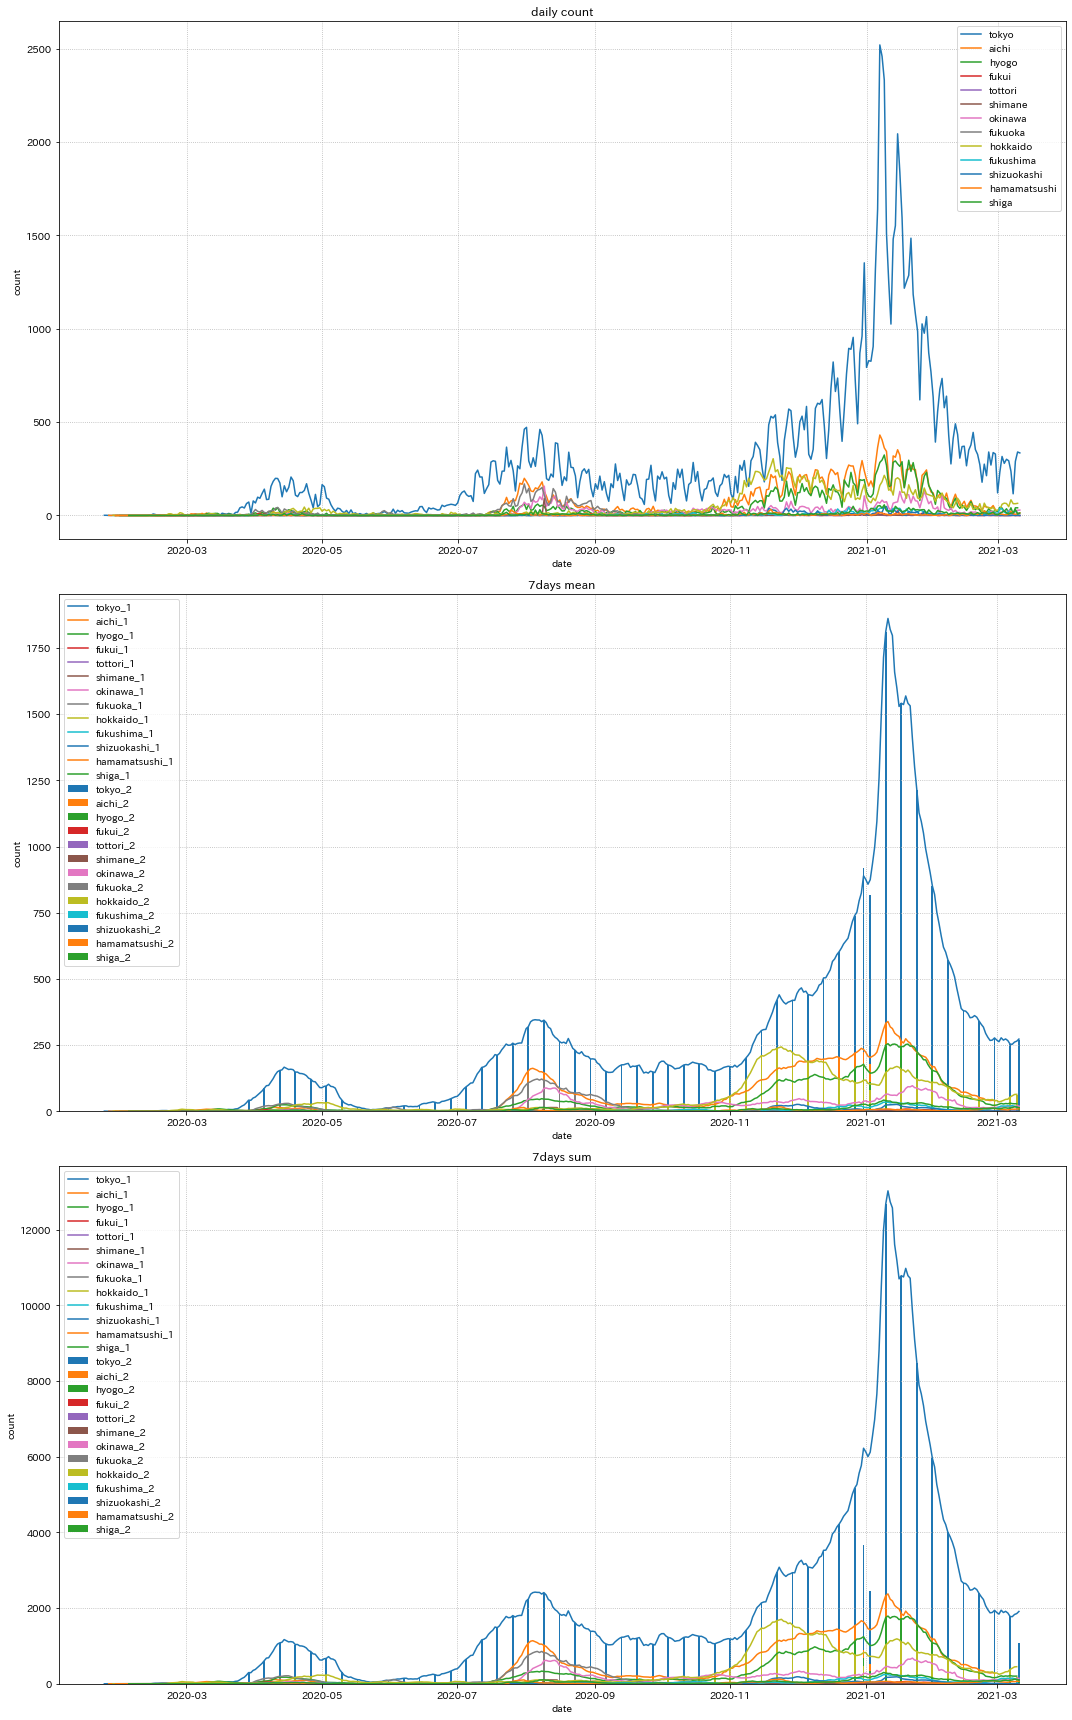

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

for k, v in tqdm(dfs.items()):
    x = v.index
    y1 = v['patients_count']
    ax[0].plot(x, y1, label=k)
    
    y2_1 = v['7d_mov_ave']
    ax[1].plot(x, y2_1, label=f"{k}_1")
    y2_2 = v['week_mean']
    ax[1].bar(x, y2_2, label=f"{k}_2")
    
    y3_1 = v['7d_mov_sum']
    ax[2].plot(x, y3_1, label=f"{k}_1")
    y3_2 = v['week_sum']
    ax[2].bar(x, y3_2, label=f"{k}_2")

for i, _ax in tqdm(enumerate(ax)):
    _ax.set_title(titles[i])
    _ax.set_xlabel('date')
    _ax.set_ylabel('count')
    _ax.grid(linestyle=':')
    _ax.legend()

plt.tight_layout()